# Data preparation

This notebook:
- downloads the Mpro datasets from usegalaxy.eu
- reads each SDF file into a dataframe using RDKit's PandasTools
- merges them into one dataset keeping the top TransFSScore for eaach molecule across all targets
- removes unused columns and fixes data types
- writes out the contents of the resulting dataframe as
 - Mpro_16_data.pkl.gz - a pickle for quick reading as a dataframe
 - Mpro_16_data.sdf.gz - a SDF with all the records that have been retained 
 - Mpro_16_data.smi.gz - a file containing just the SMILES

Note: the SMILES is that of the candidate molecule from the fragment network prior to charge enumeration. The CTAB block in the SDF may correspond to a different charge state of that moelcule.

Note: You will typically not need to run this notebook as the 3 outputs are stored in version control and can be used for further analysis. The notebook takes ~30 mins to run and uses several GB of RAM.

Note: the data consists of 16 of the original 17 fragment screening hits. Mpro-x1093 is currently omitted as it is giving inconsistent docking results. We hope to address this and inlcude it at a later stage.

Analysis of the results of this data preparation can be found in:
- [2_InititalDataAnalysis.ipynb]() - basic analysis of the results
- [3_AugmentationAndFiltering.ipynb]() - augmentation and filtering of the results

In [205]:
import pandas as pd
import numpy as np

import os, glob, gzip

In [206]:
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import PandasTools


In [61]:
# First we need to download the data.
# Only do this once, but it can take 15 mins or so! Each SDF is ~150MB in size.
# If the file details change look here for the latest:
# https://covid19.galaxyproject.org/cheminformatics/Histories/#galaxy-histories-provenance-information-included

if os.path.isdir('Mpro_16_data'):
    raise Exception("Data dir already exists - if you really need to re-load the data delete this dir first")

!mkdir Mpro_16_data
!wget https://usegalaxy.eu/datasets/11ac94870d0bb33af9ff88ff05d7ac37/display?to_ext=sdf -O Mpro_16_data/Mpro-x0072.sdf
!wget https://usegalaxy.eu/datasets/11ac94870d0bb33a8e417ea0c6ac89a3/display?to_ext=sdf -O Mpro_16_data/Mpro-x0104.sdf
!wget https://usegalaxy.eu/datasets/11ac94870d0bb33a3d2d47263467aa39/display?to_ext=sdf -O Mpro_16_data/Mpro-x0107.sdf
!wget https://usegalaxy.eu/datasets/11ac94870d0bb33abe1b6cbc841cabee/display?to_ext=sdf -O Mpro_16_data/Mpro-x0161.sdf
!wget https://usegalaxy.eu/datasets/11ac94870d0bb33a7f567e7c1cda8dfd/display?to_ext=sdf -O Mpro_16_data/Mpro-x0195.sdf
!wget https://usegalaxy.eu/datasets/11ac94870d0bb33a8068598a0af2efb7/display?to_ext=sdf -O Mpro_16_data/Mpro-x0305.sdf
!wget https://usegalaxy.eu/datasets/11ac94870d0bb33abe0b0affbac4286a/display?to_ext=sdf -O Mpro_16_data/Mpro-x0354.sdf
!wget https://usegalaxy.eu/datasets/11ac94870d0bb33afdbeeb1be2406a75/display?to_ext=sdf -O Mpro_16_data/Mpro-x0387.sdf
!wget https://usegalaxy.eu/datasets/11ac94870d0bb33ae11f10f4abb2e6eb/display?to_ext=sdf -O Mpro_16_data/Mpro-x0434.sdf
!wget https://usegalaxy.eu/datasets/11ac94870d0bb33aa70734a58ac90aec/display?to_ext=sdf -O Mpro_16_data/Mpro-x0540.sdf
!wget https://usegalaxy.eu/datasets/11ac94870d0bb33a550be4e37e8e596a/display?to_ext=sdf -O Mpro_16_data/Mpro-x0678.sdf
!wget https://usegalaxy.eu/datasets/11ac94870d0bb33a5e644fe42c0d297d/display?to_ext=sdf -O Mpro_16_data/Mpro-x0874.sdf
!wget https://usegalaxy.eu/datasets/11ac94870d0bb33a896ad0c9ff85ddc1/display?to_ext=sdf -O Mpro_16_data/Mpro-x0946.sdf
!wget https://usegalaxy.eu/datasets/11ac94870d0bb33ad8b8cf8c82ef4627/display?to_ext=sdf -O Mpro_16_data/Mpro-x0995.sdf
!wget https://usegalaxy.eu/datasets/11ac94870d0bb33a8b8f3d747e35f32a/display?to_ext=sdf -O Mpro_16_data/Mpro-x1077.sdf
!wget https://usegalaxy.eu/datasets/11ac94870d0bb33aaf300ab710fe11e0/display?to_ext=sdf -O Mpro_16_data/Mpro-x1249.sdf

Exception: Data dir already exists - if you really need to re-load the data delete this dir first

In [207]:
# Load and merge the datasets and merge into a single dataframe
# This takes about 10 mins

files =  glob.glob('Mpro_16_data/Mpro-x*.sdf')
df1 = None
count = 0
for file in files:
    count += 1
    name = file[13:23]
    print('Loading dataset', count, name)
    df2 = PandasTools.LoadSDF(file, molColName='Molecule')
    print('  read', df2.shape)
    df2['Target'] = name
    if df1 is None:
        df1 = df2
    else:
        df1 = df1.append(df2)
        df1 = df1.groupby(["Name"])
        df1 = df1.apply(lambda x: x.sort_values(['TransFSScore'], ascending=False))
        df1 = df1.reset_index(drop=True)
        df1 = df1.groupby('Name').head(1)
    print('  dataframe shape:', df1.shape)
    
print('Loading complete')

Loading dataset 1 Mpro-x0305
  read (41582, 50)
  dataframe shape: (41582, 51)
Loading dataset 2 Mpro-x0107
  read (41582, 50)
  dataframe shape: (41582, 51)
Loading dataset 3 Mpro-x0874
  read (41582, 50)
  dataframe shape: (41582, 51)
Loading dataset 4 Mpro-x0678
  read (41582, 50)
  dataframe shape: (41582, 51)
Loading dataset 5 Mpro-x0995
  read (41582, 50)
  dataframe shape: (41582, 51)
Loading dataset 6 Mpro-x0072
  read (41582, 50)
  dataframe shape: (41582, 51)
Loading dataset 7 Mpro-x1249
  read (41582, 50)
  dataframe shape: (41582, 51)
Loading dataset 8 Mpro-x0354
  read (41582, 50)
  dataframe shape: (41582, 51)
Loading dataset 9 Mpro-x0161
  read (41582, 50)
  dataframe shape: (41582, 51)
Loading dataset 10 Mpro-x0387
  read (41582, 50)
  dataframe shape: (41582, 51)
Loading dataset 11 Mpro-x0195
  read (41582, 50)
  dataframe shape: (41582, 51)
Loading dataset 12 Mpro-x1077
  read (41582, 50)
  dataframe shape: (41582, 51)
Loading dataset 13 Mpro-x0946
  read (41582, 50)


In [170]:
# Drop the columns we don't need and rename some

columns_to_remove = ['CHROM.0', 'CHROM.1', 'RI', 'Rbt.Current_Directory', 'Rbt.Executable', 'Rbt.Library', 
                     'Rbt.Parameter_File', 'Rbt.Receptor', 'Name', 'SCORE.INTER', 'SCORE.INTER.CONST',
                     'SCORE.INTER.POLAR', 'SCORE.INTER.REPUL', 'SCORE.INTER.ROT', 'SCORE.INTER.VDW',
                     'SCORE.INTER.norm', 'SCORE.INTRA', 'SCORE.INTRA.DIHEDRAL', 'SCORE.INTRA.DIHEDRAL.0',
                     'SCORE.INTRA.POLAR', 'SCORE.INTRA.POLAR.0', 'SCORE.INTRA.REPUL', 'SCORE.INTRA.REPUL.0',
                     'SCORE.INTRA.VDW', 'SCORE.INTRA.VDW.0', 'SCORE.INTRA.norm', 'SCORE.RESTR',
                     'SCORE.RESTR.norm', 'SCORE.SYSTEM', 'SCORE.SYSTEM.CONST', 'SCORE.SYSTEM.DIHEDRAL',
                     'SCORE.SYSTEM.POLAR', 'SCORE.SYSTEM.REPUL', 'SCORE.SYSTEM.VDW', 'SCORE.heavy',
                     'SCORE.SYSTEM.norm', 'TransFSReceptor', 'Name', 'Max_SuCOS_Cluster'
                    ]

columns_to_rename = { 'ID': 'NSMILES'} # NSMILES means Neutral SMILES e.g. prior to charge enumeration

df3 = df1.drop(columns=columns_to_remove)
df3 = df3.rename(columns=columns_to_rename)

# Replace nan in the SuCOS scores with 0.
# This is not ideal, but pandas does't handle nan very well, especially for int columns
df3 = df3.replace({
    'Max_SuCOS_Score': np.nan, 
    'Max_SuCOS_FeatureMap_Score': np.nan, 
    'Max_SuCOS_Protrude_Score': np.nan,
    'Max_SuCOS_Index': np.nan,
    'Cum_SuCOS_Score': np.nan,
    'Cum_SuCOS_FeatureMap_Score': np.nan,
    'Cum_SuCOS_Protrude_Score': np.nan}, 0)

df3.shape

(41582, 13)

,SCORE,SCORE.norm,TransFSScore,Max_SuCOS_Score,Max_SuCOS_FeatureMap_Score,Max_SuCOS_Protrude_Score,Max_SuCOS_Index,Cum_SuCOS_Score,Cum_SuCOS_FeatureMap_Score,Cum_SuCOS_Protrude_Score,NSMILES,Molecule,Target
0,-14.4733,-1.31576,0.162173,0,0,0,0,0,0,0,BrC(Br)=Cc1ccc(Br)cc1,,Mpro-x0678
2,-30.9106,-3.09106,0.078375,0.28408925222790621,0.024352181525011923,0.54382632293080047,13,2.0788118504268129,0.42437739701463245,3.7332463038389934,BrC(Br)=Cc1ccncn1,,Mpro-x0104
4,-33.4132,-3.34132,0.076633,0.31791960112462903,0.17980436193403621,0.4560348403152219,2,2.0722995754210927,0.39416065131006656,3.7504384995321205,BrC(Br)=Cc1cncnc1,,Mpro-x0104
6,-15.4443,-0.90849,0.178053,0.43443445583142859,0.1518826842796544,0.71698622738320283,13,3.9009128453033139,1.1536264136472147,6.6481992769594127,BrC(CCC1CCCCC1)Cc1ccccn1,,Mpro-x1249
8,-23.7233,-1.39549,0.431011,0.30899054883053778,0.099810219201388481,0.51817087845968712,8,3.2102723000354656,0.57875985863282964,5.8417847414381008,BrC(CCC1CCCCC1)Cc1ccncc1,,Mpro-x0678

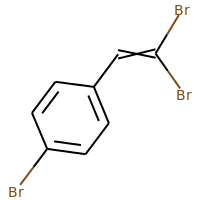
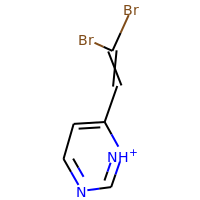
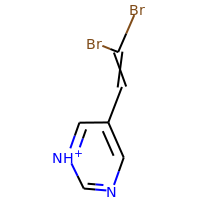
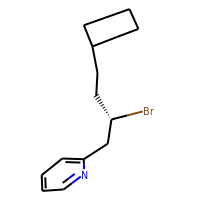
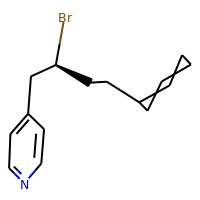

In [171]:
df3.head()

In [172]:
df3.dtypes

SCORE                         object
SCORE.norm                    object
TransFSScore                  object
Max_SuCOS_Score               object
Max_SuCOS_FeatureMap_Score    object
Max_SuCOS_Protrude_Score      object
Max_SuCOS_Index               object
Cum_SuCOS_Score               object
Cum_SuCOS_FeatureMap_Score    object
Cum_SuCOS_Protrude_Score      object
NSMILES                       object
Molecule                      object
Target                        object
dtype: object

In [173]:
# Sod it! RDKit does not assign correct dtypes. We'll need to set them manually

df3 = df3.astype(dtype= {
    "Cum_SuCOS_FeatureMap_Score":"float64",
    "Cum_SuCOS_Protrude_Score":"float64",
    "Cum_SuCOS_Score":"float64",
    "Max_SuCOS_Index":"float64",
    "Max_SuCOS_FeatureMap_Score":"float64",
    "Max_SuCOS_Protrude_Score":"float64",
    "Max_SuCOS_Score":"float64",
    "SCORE":"float64",
    "SCORE.norm":"float64",
    "TransFSScore":"float64"
})
df3 =  df3.astype(dtype= {
    "Max_SuCOS_Index":"Int64",
})

In [174]:
df3.dtypes

SCORE                         float64
SCORE.norm                    float64
TransFSScore                  float64
Max_SuCOS_Score               float64
Max_SuCOS_FeatureMap_Score    float64
Max_SuCOS_Protrude_Score      float64
Max_SuCOS_Index                 Int64
Cum_SuCOS_Score               float64
Cum_SuCOS_FeatureMap_Score    float64
Cum_SuCOS_Protrude_Score      float64
NSMILES                        object
Molecule                       object
Target                         object
dtype: object

In [193]:
# This methods provides a simple way to re-order columns.
# See https://towardsdatascience.com/reordering-pandas-dataframe-columns-thumbs-down-on-standard-solutions-1ff0bc2941d5

def movecol(df, cols_to_move=[], ref_col='', place='After'):
    
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

In [198]:
# Re-order colums to be more friendly

df3 = movecol(df3, 
             cols_to_move=['NSMILES','Molecule','Target','TransFSScore'], 
             ref_col='SCORE',
             place='Before')

,NSMILES,Molecule,Target,TransFSScore,SCORE,SCORE.norm,Max_SuCOS_Score,Max_SuCOS_FeatureMap_Score,Max_SuCOS_Protrude_Score,Max_SuCOS_Index,Cum_SuCOS_Score,Cum_SuCOS_FeatureMap_Score,Cum_SuCOS_Protrude_Score
0,BrC(Br)=Cc1ccc(Br)cc1,,Mpro-x0678,0.162173,-14.4733,-1.31576,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
2,BrC(Br)=Cc1ccncn1,,Mpro-x0104,0.078375,-30.9106,-3.09106,0.284089,0.024352,0.543826,13,2.078812,0.424377,3.733246
4,BrC(Br)=Cc1cncnc1,,Mpro-x0104,0.076633,-33.4132,-3.34132,0.317920,0.179804,0.456035,2,2.072300,0.394161,3.750438
6,BrC(CCC1CCCCC1)Cc1ccccn1,,Mpro-x1249,0.178053,-15.4443,-0.90849,0.434434,0.151883,0.716986,13,3.900913,1.153626,6.648199
8,BrC(CCC1CCCCC1)Cc1ccncc1,,Mpro-x0678,0.431011,-23.7233,-1.39549,0.308991,0.099810,0.518171,8,3.210272,0.578760,5.841785

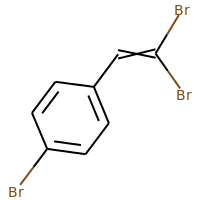
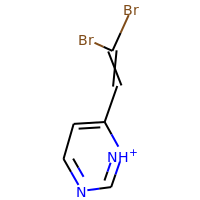
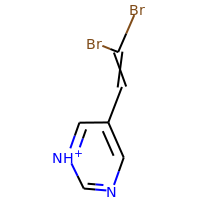
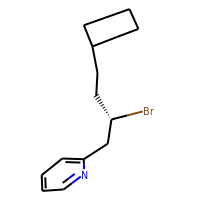
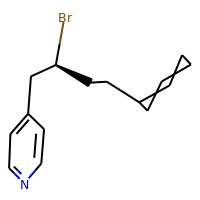

In [199]:
df3.head()

In [202]:
# Save dataframe as a pickle for easy re-use
df3.to_pickle("./Mpro_16_data.pkl.gz")

In [203]:
# Save dataframe as SDF
PandasTools.WriteSDF(df3, './Mpro_16_data.sdf.gz', molColName='Molecule', idName='NSMILES', properties=list(df3.columns))

In [204]:
# Save the SMILES from the dataframe
smiles = df3['NSMILES']
with gzip.open('./Mpro_16_data.smi.gz', 'wt') as output:
    for s in smiles:
        output.write(str(s) + '\n')